In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import seaborn as sns

plt.style.use('fivethirtyeight')

In [2]:
# import and drop 'Rk' column
df_raw = pd.read_csv('nba_rs_2019_20.csv')
df_col_raw = df_raw.drop('Rk', axis=1)

In [3]:
# when players are traded during the season, they receive an additional row entry during their time on that team
# an additional row for each player is given summarizing their entire season regardless of team (Tm = TOT)
# create a mask that: finds all players with multiple name entries and don't have 'TOT' as their team listing
mask = (df_col_raw.duplicated(['Player'], keep=False)) & (df_col_raw['Tm'] !=  'TOT')

# inspect team column to insure that only individual team row entries were removed, sparing the season total row entries
df_col_raw.loc[mask]['Tm'].value_counts()

MIN    16
GSW     8
SAC     8
DEN     8
DET     8
ATL     7
MEM     7
CLE     6
POR     5
PHI     5
HOU     5
LAC     5
WAS     5
LAL     4
MIA     4
UTA     3
DAL     3
BRK     3
PHO     2
NYK     2
MIL     2
CHO     2
ORL     2
SAS     1
TOR     1
Name: Tm, dtype: int64

In [4]:
# use ~mask to create now dataframe to import the opposite of the mask
df_no_dups = df_col_raw.loc[~mask]

# set players column as the index
df_no_dups = df_no_dups.set_index('Player')

In [5]:
# exclude players with appearances below the median value of games and who played below the median value of games per minute
mask2 = (df_no_dups['G'] > df_no_dups['G'].median()) & (df_no_dups['MP'] > df_no_dups['MP'].median())
df_mask2 = df_no_dups.loc[mask2]
df_mask2.values.shape

(200, 28)

In [6]:
# fill missing values in with zero
df_fill = df_mask2.fillna(0)

# inspect dataframe for missing values
df_fill.isnull().sum()

Pos     0
Age     0
Tm      0
G       0
GS      0
MP      0
FG      0
FGA     0
FG%     0
3P      0
3PA     0
3P%     0
2P      0
2PA     0
2P%     0
eFG%    0
FT      0
FTA     0
FT%     0
ORB     0
DRB     0
TRB     0
AST     0
STL     0
BLK     0
TOV     0
PF      0
PTS     0
dtype: int64

In [7]:
# to prepare for clustering analysis remove non-relevant columns from dataset
# position, age, team
drop_cols = ['Pos', 'Age', 'Tm']
df_num = df_fill.drop(drop_cols, axis=1)

In [8]:
# use standard scaler to normalize the scale of the data
scaled_vals = StandardScaler().fit_transform(df_num)

# dataframe currently contains 28 columns of variables, PCA will be applied to reduce the dimensionality of the data
# data will be reduced to retain 95% of the variance
pca_vals = PCA(0.95).fit_transform(scaled_vals)

# inspect shape of processed data
pca_vals.shape

(200, 11)

C:\Users\remig\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


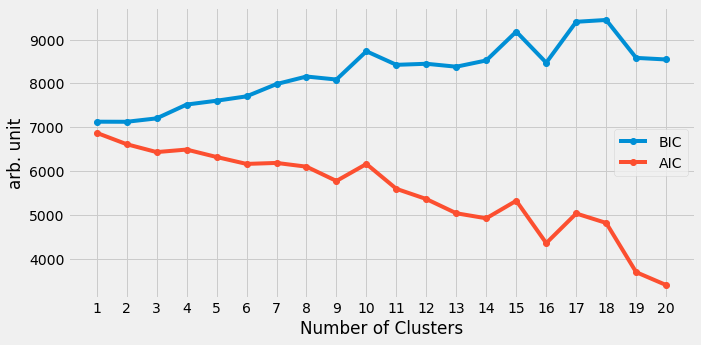

In [9]:
# use GMM ranging from 1 to 20 clusters to find the optimal number of clusters
models = [GaussianMixture(i).fit(pca_vals) for i in range(1,21)]

# access AIC and BIC of each model and search for clusters with lower AIC and BIC values
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(1,21), [m.bic(pca_vals) for m in models], marker='o', label='BIC')
ax.plot(range(1,21), [m.aic(pca_vals) for m in models], marker='o', label='AIC')
ax.set_xlabel('Number of Clusters')
ax.set_xticks(range(1,21))
ax.set_ylabel('arb. unit')
ax.legend(loc=5)
plt.show()

In [10]:
# no optimal grouping; use 11 clusters 
gmm = GaussianMixture(n_components=11, random_state=42)
gmm.fit(pca_vals)
labels = gmm.predict(pca_vals)

# add 1 to each label so clusters start at 1 instead of 0
clusters = 1 + labels

In [11]:
# further reduce processed data (pca_vals) to 2 dimensions in order to visualize easily
pca_2d = PCA(2)
vis = pca_2d.fit_transform(pca_vals)

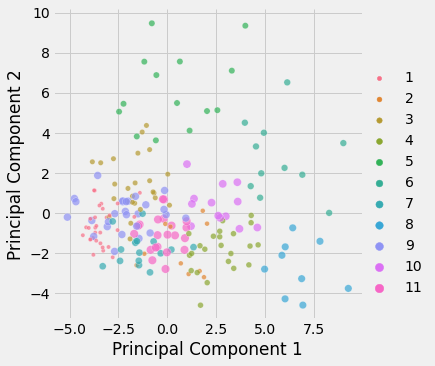

In [12]:
# graph
df_vis = pd.DataFrame(vis, columns=['Principal Component 1', 'Principal Component 2'])

sns.relplot(x='Principal Component 1', y='Principal Component 2', 
            data=df_vis, kind='scatter', hue=clusters, 
            size=clusters, palette=sns.color_palette('husl', 11), 
            legend='full', alpha=0.7)

plt.show()

In [13]:
# attach cluster labels to df_fill
df_fill['Cluster'] = clusters

# filter for general statistics columns
cols_final = ['Cluster', 'MP', 'PTS', '2P%', '3P%', 'FT%', 'AST', 'TRB', 'STL', 'BLK']
df_final = df_fill.loc[:, cols_final]

In [14]:
# create cluster summary table
cols_summ = ['MP', 'PTS', '2P%', '3P%', 'FT%', 'AST', 'TRB', 'STL', 'BLK']
cluster_summary = df_final.groupby('Cluster')[cols_summ].mean()
cluster_summary

,MP,PTS,2P%,3P%,FT%,AST,TRB,STL,BLK
Cluster,,,,,,,,,
1,22.787097,9.309677,0.507548,0.387226,0.815323,1.925806,2.912903,0.661290,0.232258
2,30.380000,17.500000,0.501800,0.397100,0.862600,2.610000,5.130000,0.730000,0.330000
3,26.792000,9.988000,0.581240,0.369560,0.764280,1.612000,5.260000,0.876000,0.760000
4,32.717391,19.400000,0.493348,0.356087,0.832435,5.547826,4.473913,1.139130,0.365217
5,25.321429,11.435714,0.615357,0.159643,0.643929,1.571429,9.007143,0.607143,1.264286
6,33.236364,21.436364,0.556364,0.263364,0.732182,5.027273,10.263636,1.263636,0.927273
7,26.443750,12.556250,0.468812,0.344687,0.831937,3.062500,3.293750,0.781250,0.243750
8,35.177778,28.633333,0.531778,0.360667,0.834778,7.277778,5.855556,1.266667,0.422222
9,24.488889,9.100000,0.503556,0.330444,0.761667,2.622222,3.751852,1.055556,0.355556


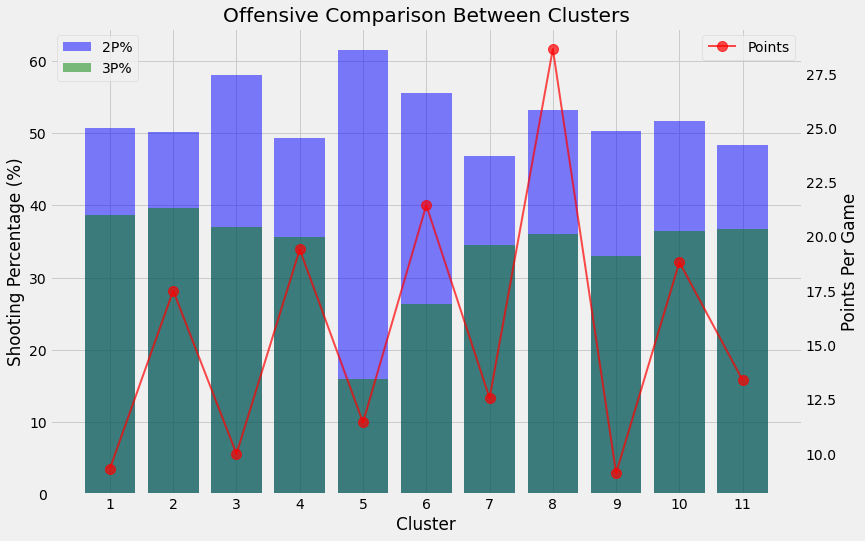

In [15]:
# offensive cluster conparison

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(cluster_summary.index, cluster_summary['2P%'] * 100, color='blue', alpha=0.5, label='2P%')
ax.bar(cluster_summary.index, cluster_summary['3P%'] * 100, color='green', alpha=0.5, label='3P%')
ax.set_xticks(range(1,12))
ax.set_xlabel('Cluster')
ax.set_ylabel('Shooting Percentage (%)')
ax.set_title('Offensive Comparison Between Clusters')

ax2 = ax.twinx()
ax2.plot(cluster_summary.index, cluster_summary['PTS'], color='red',
        label='Points', marker='o', markersize=10, linewidth=2,
        alpha=0.7)
ax2.set_ylabel('Points Per Game')

ax.legend(loc=2)
ax2.legend(loc=1)
plt.grid(b=None)
plt.show()

In [16]:
# store players indexed by cluster in a dictionary
cluster_dict = {c: df_final.loc[df_final['Cluster'] == c]
               for c in range(1,12)}

In [17]:
cluster_dict

{1:                           Cluster    MP   PTS    2P%    3P%    FT%  AST  TRB  \
 Player                                                                         
 Malik Beasley                   1  22.0  11.2  0.465  0.388  0.818  1.4  2.7   
 Kentavious Caldwell-Pope        1  25.5   9.3  0.541  0.385  0.775  1.6  2.1   
 Jordan Clarkson                 1  24.0  15.2  0.533  0.368  0.836  1.9  2.6   
 Seth Curry                      1  24.6  12.4  0.549  0.452  0.825  1.9  2.3   
 Bryn Forbes                     1  25.1  11.2  0.470  0.388  0.833  1.7  2.0   
 Langston Galloway               1  25.8  10.3  0.493  0.399  0.859  1.5  2.3   
 JaMychal Green                  1  20.7   6.8  0.518  0.387  0.750  0.8  6.2   
 George Hill                     1  21.5   9.4  0.565  0.460  0.842  3.1  3.0   
 Justin Holiday                  1  25.0   8.3  0.477  0.405  0.791  1.3  3.3   
 Tyus Jones                      1  19.0   7.4  0.492  0.379  0.741  4.4  1.6   
 Cory Joseph             